# 5 - Ensemble Methods - Bagging


by [Alejandro Correa Bahnsen](albahnsen.com/) and [Jesus Solano](https://github.com/jesugome)

version 1.6, June 2020

## Part of the class [Advanced Methods in Data Analysis](https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass)


This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Kevin Markham](https://github.com/justmarkham)

Why are we learning about ensembling?

- Very popular method for improving the predictive performance of machine learning models
- Provides a foundation for understanding more sophisticated models

## Lesson objectives

Students will be able to:

- Define ensembling and its requirements
- Identify the two basic methods of ensembling
- Decide whether manual ensembling is a useful approach for a given problem
- Explain bagging and how it can be applied to decision trees
- Explain how out-of-bag error and feature importances are calculated from bagged trees
- Explain the difference between bagged trees and Random Forests
- Build and tune a Random Forest model in scikit-learn
- Decide whether a decision tree or a Random Forest is a better model for a given problem

# Part 1: Introduction

Ensemble learning is a widely studied topic in the machine learning community. The main idea behind 
the ensemble methodology is to combine several individual base classifiers in   order to have a 
classifier that outperforms each of them.

Nowadays,   ensemble methods are  one 
of the most popular and well studied machine learning techniques, and it can be 
noted that since 2009 all the first-place and   second-place winners of the KDD-Cup https://www.sigkdd.org/kddcup/   used  ensemble methods. The core 
principle in ensemble learning, is to induce random perturbations into  the learning procedure in 
order to produce several different base classifiers from a single  training set, then combining the 
base classifiers in order to make the final prediction.  In order to induce the random permutations 
and therefore create the different base classifiers,   several methods have been proposed, in 
particular: 
* bagging
* pasting
* random forests 
* random patches  

Finally, after  the base   classifiers 
are trained, they are typically   combined using either:
* majority voting
* weighted  voting  
* stacking


There are three main reasons regarding why ensemble 
methods perform better than single models: statistical, computational and representational . First, from a statistical point of view, when the learning set is too 
small, an algorithm can find several good models within the search space, that arise to the same 
performance on the training set $\mathcal{S}$. Nevertheless, without a validation set, there is 
a risk of choosing the wrong model. The second reason is computational; in general, algorithms 
rely on some local search optimization and may get stuck in a local optima. Then, an ensemble may 
solve this by focusing different algorithms to different spaces across the training set. The last 
reason is representational. In most cases, for a learning set of finite size, the  true function 
$f$ cannot be represented by any of the candidate models. By combining several  models in an 
ensemble, it may be possible to obtain a model with a larger coverage across the  space of 
representable functions.

![](ch9_fig1.png)

## Example

Let's pretend that instead of building a single model to solve a binary classification problem, you created **five independent models**, and each model was correct about 70% of the time. If you combined these models into an "ensemble" and used their majority vote as a prediction, how often would the ensemble be correct?

In [1]:
import numpy as np

# set a seed for reproducibility
np.random.seed(1234)

# generate 1000 random numbers (between 0 and 1) for each model, representing 1000 observations
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# print the first 20 predictions from each model
print(preds1[:20])
print(preds2[:20])
print(preds3[:20])
print(preds4[:20])
print(preds5[:20])

[0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0]
[1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1]
[1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0]
[0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1]


In [2]:
# average the predictions and then round to 0 or 1
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)

# print the ensemble's first 20 predictions
print(ensemble_preds[:20])

[1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1]


In [3]:
# how accurate was each individual model?
print(preds1.mean())
print(preds2.mean())
print(preds3.mean())
print(preds4.mean())
print(preds5.mean())

0.713
0.665
0.717
0.712
0.687


In [4]:
# how accurate was the ensemble?
print(ensemble_preds.mean())

0.841


**Note:** As you add more models to the voting process, the probability of error decreases, which is known as [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).

## What is ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform the null model
- **Independent:** their predictions are generated using different processes

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

There are two basic **methods for ensembling:**

- Manually ensemble your individual models
- Use a model that ensembles for you

### Theoretical performance of an ensemble
  If we assume that each one of the $T$ base classifiers has a probability $\rho$ of 
  being correct, the probability of an ensemble making the correct decision, assuming independence, 
  denoted by $P_c$, can be calculated using the binomial distribution

$$P_c = \sum_{j>T/2}^{T} {{T}\choose{j}} \rho^j(1-\rho)^{T-j}.$$

  Furthermore, as shown, if $T\ge3$ then:

$$
  \lim_{T \to  \infty} P_c= \begin{cases} 
            1  &\mbox{if } \rho>0.5 \\ 
            0  &\mbox{if } \rho<0.5 \\ 
            0.5  &\mbox{if } \rho=0.5 ,
            \end{cases}
$$
	leading to the conclusion that 
$$
  \rho \ge 0.5 \quad \text{and} \quad T\ge3 \quad \Rightarrow \quad P_c\ge \rho.
$$

# Part 2: Manual ensembling

What makes a good manual ensemble?

- Different types of **models**
- Different combinations of **features**
- Different **tuning parameters**

![Machine learning flowchart](https://raw.githubusercontent.com/justmarkham/DAT8/master/notebooks/images/crowdflower_ensembling.jpg)

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*

In [5]:
# read in and prepare the vehicle training data
import pandas as pd
url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/vehicles_train.csv'
train = pd.read_csv(url)
train['vtype'] = train.vtype.map({'car':0, 'truck':1})
# read in and prepare the vehicle testing data
url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})

In [6]:
train.head()

,price,year,miles,doors,vtype
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0


### Train different models

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor

models = {'lr': LinearRegression(),
          'dt': DecisionTreeRegressor(),
          'nb': GaussianNB(),
          'kn': KNeighborsRegressor()}

In [8]:
# Train all the models
X_train = train.iloc[:, 1:]
X_test = test.iloc[:, 1:]
y_train = train.price
y_test = test.price

for model in models.keys():
    models[model].fit(X_train, y_train)

In [9]:
# predict test for each model
y_pred = pd.DataFrame(index=test.index, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)
    

In [10]:
# Evaluate each model
from sklearn.metrics import mean_squared_error

for model in models.keys():
    print(model,np.sqrt(mean_squared_error(y_pred[model], y_test)))

lr 2138.3579028745116
dt 1414.213562373095
nb 5477.2255750516615
kn 1671.3268182295567


### Evaluate the error of the mean of the predictions

In [11]:
np.sqrt(mean_squared_error(y_pred.mean(axis=1), y_test))

1193.164765760328

## Comparing manual ensembling with a single model approach

**Advantages of manual ensembling:**

- Increases predictive accuracy
- Easy to get started

**Disadvantages of manual ensembling:**

- Decreases interpretability
- Takes longer to train
- Takes longer to predict
- More complex to automate and maintain
- Small gains in accuracy may not be worth the added complexity

# Part 3: Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

What is a **bootstrap sample**? A random sample with replacement:

In [12]:
# set a seed for reproducibility
np.random.seed(1)

# create an array of 1 through 20
nums = np.arange(1, 21)
print(nums)

# sample that array 20 times with replacement
print(np.random.choice(a=nums, size=20, replace=True))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**
    - Take a vote for **classification trees**

Notes:

- **Each bootstrap sample** should be the same size as the original training set.
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times an averaging the results.


In [13]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1]),
 array([ 9,  0,  0,  9,  3, 13,  4,  0,  0,  4,  1,  7,  3,  2]),
 array([ 4,  7,  2,  4,  8, 13,  0,  7,  9,  3, 12, 12,  4,  6]),
 array([ 1,  5,  6, 11,  2,  1, 12,  8,  3, 10,  5,  0, 11,  2]),
 array([10, 10,  6, 13,  2,  4, 11, 11, 13, 12,  4,  6, 13,  3]),
 array([10,  0,  6,  4,  7, 11,  6,  7,  1, 11, 10,  5,  7,  9]),
 array([ 2,  4,  8,  1, 12,  2,  1,  1,  3, 12,  5,  9,  0,  8]),
 array([11,  1,  6,  3,  3, 11,  5,  9,  7,  9,  2,  3, 11,  3]),
 array([ 3,  8,  6,  9,  7,  6,  3,  9,  6, 12,  6, 11,  6,  1]),
 array([13, 10,  3,  4,  3,  1, 13,  0,  5,  8, 13,  6, 11,  8])]

In [14]:
# show the rows for the first decision tree
train.iloc[samples[0], :]

,price,year,miles,doors,vtype
13,1300,1997,138000,4,0
2,13000,2010,73500,4,0
12,1800,1999,163000,2,1
2,13000,2010,73500,4,0
6,3000,2004,177000,4,0
1,14000,2010,30000,2,0
3,9500,2009,78000,4,0
10,2500,2003,190000,2,1
11,5000,2001,62000,4,0
9,1900,2003,160000,4,0


 Build one tree for each sample

In [15]:
from sklearn.tree import DecisionTreeRegressor

# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame for storing predicted price from each tree
y_pred = pd.DataFrame(index=test.index, columns=[list(range(n_B))])

# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred[i] = treereg.predict(X_test)

In [16]:
y_pred

,0,1,2,3,4,5,6,7,8,9
0,1300.0,1300.0,3000.0,4000.0,1300.0,4000.0,4000.0,4000.0,3000.0,4000.0
1,5000.0,1300.0,3000.0,5000.0,5000.0,5000.0,4000.0,5000.0,5000.0,5000.0
2,14000.0,13000.0,13000.0,13000.0,13000.0,14000.0,13000.0,13000.0,9500.0,9000.0


Results of each tree

In [17]:
for i in range(n_B):
    print(i, np.sqrt(mean_squared_error(y_pred[i], y_test)))

0 1621.7274740226856
1 2942.7877939124323
2 1825.7418583505537
3 1000.0
4 1276.7145334803704
5 1414.213562373095
6 1414.213562373095
7 1000.0
8 1554.5631755148024
9 1914.854215512676


Results of the ensemble

In [18]:
y_pred.mean(axis=1)

0     2990.0
1     4330.0
2    12450.0
dtype: float64

In [19]:
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

998.5823284370031

## Bagged decision trees in scikit-learn (with B=500)

In [20]:
# define the training and testing sets
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [21]:
# instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator"
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, 
                          bootstrap=True, oob_score=True, random_state=1)

In [22]:
# fit and predict
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([ 3335. ,  5419.8, 12956. ])

In [23]:
# calculate RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

673.9913550385247

## Estimating out-of-sample error

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

On average, each bagged tree uses about **two-thirds** of the observations. For each tree, the **remaining observations** are called "out-of-bag" observations.

In [24]:
# show the first bootstrap sample
samples[0]

array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1])

In [25]:
# show the "in-bag" observations for each sample
for sample in samples:
    print(set(sample))

{0, 1, 2, 3, 6, 9, 10, 11, 12, 13}
{0, 1, 2, 3, 4, 7, 9, 13}
{0, 2, 3, 4, 6, 7, 8, 9, 12, 13}
{0, 1, 2, 3, 5, 6, 8, 10, 11, 12}
{2, 3, 4, 6, 10, 11, 12, 13}
{0, 1, 4, 5, 6, 7, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 8, 9, 12}
{1, 2, 3, 5, 6, 7, 9, 11}
{1, 3, 6, 7, 8, 9, 11, 12}
{0, 1, 3, 4, 5, 6, 8, 10, 11, 13}


In [26]:
# show the "out-of-bag" observations for each sample
for sample in samples:
    print(sorted(set(range(n_samples)) - set(sample)))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]
[4, 7, 9, 13]
[0, 1, 5, 7, 8, 9]
[2, 3, 8, 12, 13]
[6, 7, 10, 11, 13]
[0, 4, 8, 10, 12, 13]
[0, 2, 4, 5, 10, 13]
[2, 7, 9, 12]


How to calculate **"out-of-bag error":**

1. For every observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a vote (for classification).
2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When B is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [27]:
# compute the out-of-bag R-squared score (not MSE, unfortunately!) for B=500
bagreg.oob_score_

0.7662607997982768

## Estimating feature importance

Bagging increases **predictive accuracy**, but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** calculate the total amount that **MSE** is decreased due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** calculate the total amount that **Gini index** is decreased due to splits over a given feature, averaged over all trees

# Part 4: Combination of classifiers - Majority Voting

  The most typical form of an ensemble is made by combining $T$ different base classifiers.
  Each  base classifier $M(\mathcal{S}_j)$ is trained by applying algorithm $M$ to a random subset 
  $\mathcal{S}_j$ of the training set $\mathcal{S}$.  
  For simplicity we define $M_j \equiv  M(\mathcal{S}_j)$ for $j=1,\dots,T$, and 
  $\mathcal{M}=\{M_j\}_{j=1}^{T}$ a set of base classifiers.
  Then, these models are combined using majority voting to create the ensemble $H$ as follows
  $$
    f_{mv}(\mathcal{S},\mathcal{M}) = max_{c \in \{0,1\}} \sum_{j=1}^T 
    \mathbf{1}_c(M_j(\mathcal{S})).
  $$


In [28]:
# read in and prepare the churn data
# Download the dataset
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/churn.csv'
data = pd.read_csv(url)

# Create X and y

# Select only the numeric features
X = data.iloc[:, [1,2,6,7,8,9,10]].astype(np.float)
# Convert bools to floats
X = X.join((data.iloc[:, [4,5]] == 'no').astype(np.float))

y = (data.iloc[:, -1] == 'True.').astype(np.int)

In [29]:
X.head()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Int'l Plan,VMail Plan
0,128.0,415.0,25.0,265.1,110.0,45.07,197.4,1.0,0.0
1,107.0,415.0,26.0,161.6,123.0,27.47,195.5,1.0,0.0
2,137.0,415.0,0.0,243.4,114.0,41.38,121.2,1.0,1.0
3,84.0,408.0,0.0,299.4,71.0,50.90,61.9,0.0,1.0
4,75.0,415.0,0.0,166.7,113.0,28.34,148.3,0.0,1.0


In [30]:
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,2850,0.855086
1,483,0.144914


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Create 100 decision trees

In [32]:
n_estimators = 100
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [33]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [34]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
438,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1345,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,1,1,0
1957,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
2148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


Predict using majority voting

In [35]:
y_pred_df.sum(axis=1)[:10]

438      2
2674     5
1345    35
1957    17
2148     3
3106     4
1786    22
321      6
3082    10
2240     5
dtype: int64

In [36]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

from sklearn import metrics
metrics.f1_score(y_pred, y_test)

0.5245901639344264

In [37]:
metrics.accuracy_score(y_pred, y_test)

0.8945454545454545

### Using majority voting with sklearn

In [38]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [39]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5241935483870966, 0.8927272727272727)

# Part 5: Combination of classifiers - Weighted Voting

The majority voting approach gives the same weight to each classfier regardless of the performance of each one. Why not take into account the oob performance of each classifier

First, in the traditional approach, a 
similar comparison of the votes of the base classifiers is made, but giving a weight $\alpha_j$ 
to each classifier $M_j$ during the voting phase
$$
  f_{wv}(\mathcal{S},\mathcal{M}, \alpha)
  =\max_{c \in \{0,1\}} \sum_{j=1}^T \alpha_j \mathbf{1}_c(M_j(\mathcal{S})),
$$
where $\alpha=\{\alpha_j\}_{j=1}^T$.
The calculation of $\alpha_j$ is related to the performance of each classifier $M_j$.
It is usually defined as the normalized misclassification error   $\epsilon$ of the base 
classifier $M_j$  in the out of bag set   $\mathcal{S}_j^{oob}=\mathcal{S}-\mathcal{S}_j$
\begin{equation}
  \alpha_j=\frac{1-\epsilon(M_j(\mathcal{S}_j^{oob}))}{\sum_{j_1=1}^T 
  1-\epsilon(M_{j_1}(\mathcal{S}_{j_1}^{oob}))}.
\end{equation}

Select each oob sample

In [40]:
samples_oob = []
# show the "out-of-bag" observations for each sample
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

Estimate the oob error of each classifier

In [41]:
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

Text(0.5, 1.0, 'OOB error of each tree')

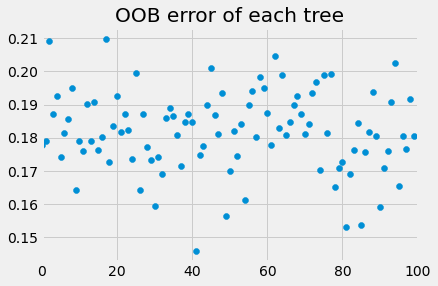

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree')

Estimate $\alpha$

In [43]:
alpha = (1 - errors) / (1 - errors).sum()

In [44]:
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)

In [45]:
weighted_sum_1.head(20)

438     0.019994
2674    0.050009
1345    0.350206
1957    0.170230
2148    0.030047
3106    0.040100
1786    0.219790
321     0.059708
3082    0.100208
2240    0.050143
1910    0.180209
2124    0.190141
2351    0.049892
1736    0.950014
879     0.039378
785     0.219648
2684    0.010104
787     0.700482
170     0.220404
1720    0.020166
dtype: float64

In [46]:
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5267489711934156, 0.8954545454545455)

### Using Weighted voting with sklearn

In [47]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5241935483870966, 0.8927272727272727)

In [48]:
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [49]:
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5418326693227091, 0.8954545454545455)

# Part 5: Combination of classifiers - Stacking

The staking method consists in combining the different base classifiers by learning a 
second level algorithm on top of them. In this framework, once the base 
classifiers are constructed using the training set  $\mathcal{S}$, a new set is constructed 
where the output of the base classifiers  are now considered as the features while keeping the 
class labels.

Even though there is no restriction on which algorithm can be used as a second level learner, 
it is common to use a linear model, such as 
$$
  f_s(\mathcal{S},\mathcal{M},\beta) =
  g \left( \sum_{j=1}^T \beta_j M_j(\mathcal{S}) \right),
$$
where $\beta=\{\beta_j\}_{j=1}^T$, and $g(\cdot)$ is the sign function 
$g(z)=sign(z)$ in the case of a linear regression or the sigmoid function, defined 
as $g(z)=1/(1+e^{-z})$, in the case of a logistic regression. 

Lets first get a new training set consisting of the output of every classifier

In [50]:
X_train_2 = pd.DataFrame(index=X_train.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    X_train_2[i] = trees[i].predict(X_train)

In [51]:
X_train_2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1412,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
626,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
from sklearn.linear_model import LogisticRegressionCV

In [53]:
lr = LogisticRegressionCV(cv = 5 )
lr.fit(X_train_2, y_train)

LogisticRegressionCV(cv=5)

In [54]:
lr.coef_

array([[0.10088464, 0.10421338, 0.09358074, 0.09660953, 0.09697781,
        0.09904032, 0.11090891, 0.09651815, 0.0935383 , 0.09123672,
        0.10193353, 0.09820731, 0.09391233, 0.09549362, 0.09152095,
        0.09644657, 0.0896993 , 0.09192601, 0.09677729, 0.09012681,
        0.09833482, 0.09514   , 0.10454839, 0.10039995, 0.09661211,
        0.09730309, 0.10910644, 0.10590111, 0.10264443, 0.10275915,
        0.10611423, 0.09792985, 0.1031922 , 0.09266752, 0.09697419,
        0.09517301, 0.08893016, 0.0989854 , 0.09045676, 0.09011887,
        0.09902678, 0.09876865, 0.10538597, 0.09571805, 0.09629428,
        0.08972837, 0.09176166, 0.08990744, 0.10143139, 0.10831536,
        0.10061968, 0.09763531, 0.08939132, 0.10073731, 0.10174935,
        0.10527521, 0.0975041 , 0.0960247 , 0.0893913 , 0.10042684,
        0.10342512, 0.10139005, 0.0902557 , 0.10340747, 0.09330728,
        0.09808251, 0.10159091, 0.0931049 , 0.0952795 , 0.1103413 ,
        0.09358935, 0.09856276, 0.10599656, 0.09

In [55]:
y_pred = lr.predict(y_pred_df)

In [56]:
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5365853658536585, 0.8963636363636364)

### Using sklearn

In [57]:
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))
X_train_3 = np.zeros((X_train.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):

    X_train_3[:, i] = clf.estimators_[i].predict(X_train)
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
lr = LogisticRegressionCV(cv=5)
lr.fit(X_train_3, y_train)

y_pred = lr.predict(y_pred_all_)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.5625000000000001, 0.8981818181818182)

vs using only one dt

In [58]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.44378698224852065, 0.8290909090909091)